In [ ]:
%reset -f
from __future__ import print_function
from __future__ import division
import math
import numpy as np
import torch
import sys
print('__Python VERSION:', sys.version)
print('__pyTorch VERSION:', torch.__version__)
print('__CUDA VERSION')
from subprocess import call
# call(["nvcc", "--version"]) does not work
! nvcc --version
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__Devices')
call(["nvidia-smi", "--format=csv", "--query-gpu=index,name,driver_version,memory.total,memory.used,memory.free"])
print('Active CUDA Device: GPU', torch.cuda.current_device())

print ('Available devices ', torch.cuda.device_count())
print ('Current cuda device ', torch.cuda.current_device())
from torch import device as torch_device

#devices = [torch_device('cuda', i) for i in range(torch.cuda.device_count())] + [torch_device('cpu')]
#print(devices)
desired_gpu_index = 1
device = torch.device(f'cuda:{desired_gpu_index}')
device

In [1]:
import os
import numpy as np
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [2]:
from monai.utils import first, set_determinism
from monai.transforms import (
    AsDiscrete,
    AsDiscreted,
    EnsureChannelFirstd,
    Compose,
    CropForegroundd,
    LoadImaged,
    Orientationd,
    RandCropByPosNegLabeld,
    SaveImaged,
    ScaleIntensityRanged,
    Spacingd,
    Invertd,
)
from monai.handlers.utils import from_engine
from monai.networks.nets import UNet
from monai.networks.layers import Norm
from monai.metrics import DiceMetric
from monai.losses import DiceLoss
from monai.inferers import sliding_window_inference
from monai.data import CacheDataset, DataLoader, Dataset, decollate_batch
from monai.config import print_config
from monai.apps import download_and_extract
import tempfile
import shutil

In [3]:
import random
random.seed(20)
np.random.seed(20)
torch.manual_seed(20)
torch.cuda.manual_seed(20)
set_determinism(seed=20)
device

device(type='cuda')

In [4]:
import cv2
import glob
import random
from tqdm import tqdm
import skimage.io as io
import skimage.transform as trans
import matplotlib.pyplot as plt
import pydicom
import SimpleITK as sitk
import nibabel as nib
from scipy import ndimage
from torchmetrics import Dice
import torch.optim as optim


import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import torch.nn as nn
from torchvision import transforms as T
import torchvision
import torch.nn.functional as F
from torch.autograd import Variable
from PIL import Image
import albumentations as A
import time
from tqdm.notebook import tqdm
from torchsummary import summary


In [5]:
train_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
        RandCropByPosNegLabeld(
            keys=["image", "label"],
            label_key="label",
            spatial_size=(96, 96, 96),
            pos=1,
            neg=1,
            num_samples=4,
            image_key="image",
            image_threshold=0,
        ),
        # user can also add other random transforms
        # RandAffined(
        #     keys=['image', 'label'],
        #     mode=('bilinear', 'nearest'),
        #     prob=1.0, spatial_size=(96, 96, 96),
        #     rotate_range=(0, 0, np.pi/15),
        #     scale_range=(0.1, 0.1, 0.1)),
    ]
)
val_transforms = Compose(
    [
        LoadImaged(keys=["image", "label"]),
        EnsureChannelFirstd(keys=["image", "label"]),
        ScaleIntensityRanged(
            keys=["image"],
            a_min=-57,
            a_max=164,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        CropForegroundd(keys=["image", "label"], source_key="image"),
        Orientationd(keys=["image", "label"], axcodes="RAS"),
        Spacingd(keys=["image", "label"], pixdim=(1.5, 1.5, 2.0), mode=("bilinear", "nearest")),
    ]
)

/home/rabeea/anaconda3/envs/tor/lib/python3.10/site-packages/monai/utils/deprecate_utils.py:321: FutureWarning: monai.transforms.io.dictionary LoadImaged.__init__:image_only: Current default value of argument `image_only=False` has been deprecated since version 1.1. It will be changed to `image_only=True` in version 1.3.
  warn_deprecated(argname, msg, warning_category)


In [6]:
imgpath = sorted(glob.glob(r"/home/rabeea/Task09_Spleen/imagesTr/*.gz", recursive = True))
maskpath = sorted(glob.glob(r"/home/rabeea/Task09_Spleen/labelsTr/*.gz", recursive = True))
tr = 28
val = 5
ts = 8
random.Random(42).shuffle(imgpath)
random.Random(42).shuffle(maskpath)
trainpath = imgpath[:tr]
trainpath_m = maskpath[:tr]
valpath = imgpath[tr:tr+val]
valpath_m = maskpath[tr:tr+val]
testpath = imgpath[tr+val:]
testpath_m = maskpath[tr+val:]
print(len(imgpath), len(trainpath), len(valpath), len(testpath))
print(valpath[:3],valpath_m[:3])

41 28 5 8
['/home/rabeea/Task09_Spleen/imagesTr/spleen_13.nii.gz', '/home/rabeea/Task09_Spleen/imagesTr/spleen_10.nii.gz', '/home/rabeea/Task09_Spleen/imagesTr/spleen_63.nii.gz'] ['/home/rabeea/Task09_Spleen/labelsTr/spleen_13.nii.gz', '/home/rabeea/Task09_Spleen/labelsTr/spleen_10.nii.gz', '/home/rabeea/Task09_Spleen/labelsTr/spleen_63.nii.gz']


In [7]:
train_files = [{"image": image_name, "label": label_name} for image_name, label_name in zip(trainpath, trainpath_m)]
val_files = [{"image": image_name, "label": label_name} for image_name, label_name in zip(valpath, valpath_m)]
test_files = [{"image": image_name, "label": label_name} for image_name, label_name in zip(testpath, testpath_m)]
val_files[:2]

[{'image': '/home/rabeea/Task09_Spleen/imagesTr/spleen_13.nii.gz',
  'label': '/home/rabeea/Task09_Spleen/labelsTr/spleen_13.nii.gz'},
 {'image': '/home/rabeea/Task09_Spleen/imagesTr/spleen_10.nii.gz',
  'label': '/home/rabeea/Task09_Spleen/labelsTr/spleen_10.nii.gz'}]

image shape: torch.Size([4, 1, 96, 96, 96]), label shape: torch.Size([4, 1, 96, 96, 96])


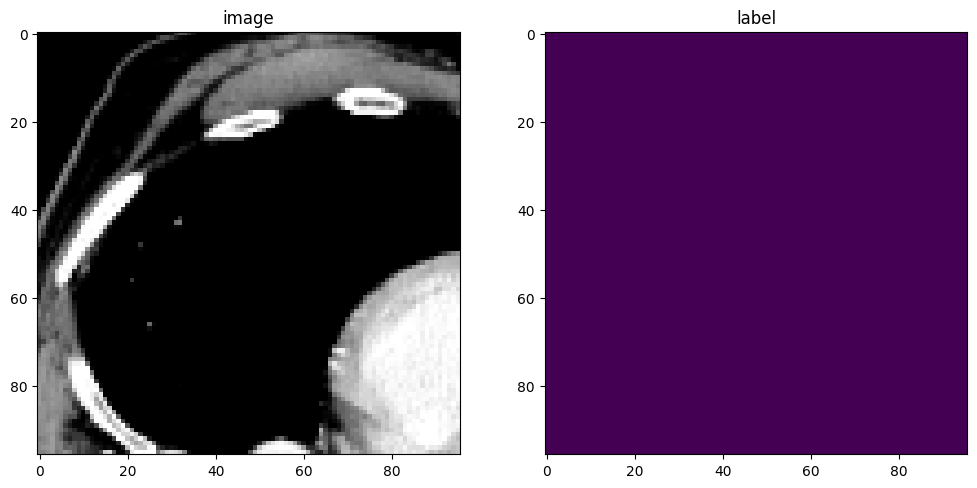

In [8]:
check_ds = Dataset(data=train_files, transform=train_transforms)
check_loader = DataLoader(check_ds, batch_size=1)
check_data = first(check_loader)
image, label = (check_data["image"], check_data["label"])
print(f"image shape: {image.shape}, label shape: {label.shape}")
# plot the slice [:, :, 80]
plt.figure("check", (12, 6))
plt.subplot(1, 2, 1)
plt.title("image")
plt.imshow(image[0][0][:, :, 80], cmap="gray")
plt.subplot(1, 2, 2)
plt.title("label")
plt.imshow(label[0][0][:, :, 80])
plt.show()

In [9]:
#train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=4)
train_ds = Dataset(data=train_files, transform=train_transforms)

# use batch_size=2 to load images and use RandCropByPosNegLabeld
# to generate 2 x 4 images for network training
train_loader = DataLoader(train_ds, batch_size=1, shuffle=True, num_workers=1)

#val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4)
val_ds = Dataset(data=val_files, transform=val_transforms)
val_loader = DataLoader(val_ds, batch_size=1, num_workers=1)

In [10]:
heads = 2
dim = 8
embed_dim = 4

In [11]:
from TransBTS_downsample8x_skipconnection import TransBTS
_, model = TransBTS(img_dim = 96, skip = False, sk_e=embed_dim, sk_d=dim, sk_h=heads)
model.to(device)


BTS(
  (linear_encoding): Linear(in_features=128, out_features=512, bias=True)
  (position_encoding): LearnedPositionalEncoding()
  (pe_dropout): Dropout(p=0.1, inplace=False)
  (transformer): TransformerModel(
    (net): IntermediateSequential(
      (0): Residual(
        (fn): PreNormDrop(
          (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
          (fn): SelfAttention(
            (qkv): Linear(in_features=512, out_features=1536, bias=False)
            (attn_drop): Dropout(p=0.1, inplace=False)
            (proj): Linear(in_features=512, out_features=512, bias=True)
            (proj_drop): Dropout(p=0.1, inplace=False)
          )
        )
      )
      (1): Residual(
        (fn): PreNorm(
          (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (fn): FeedForward(
            (net): Sequential(
              (0): Linear(in_features=512, out_features=4096, bias=True)
              (1

In [12]:
#optimizer = optim.SGD(model.parameters(), lr=1e-4)#, momentum=0.9)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0002, weight_decay=1e-5, amsgrad=True)
torch.cuda.empty_cache()
max_dice = 0
train_losses = []
test_losses = []
train_dices = []
val_dices = []
decrease = 1  
not_improve=0

In [13]:
filename = '/home/rabeea/logs/TransBTS_spleen/model_16_ly4_lr4.pt'
filename_sd = '/home/rabeea/logs/TransBTS_spleen/model_16_ly4_lr4.pth'

In [14]:
epochs = 400

In [ ]:
loss_function = DiceLoss(to_onehot_y=True, softmax=True)
dice_metric = DiceMetric(include_background=False, reduction="mean")

In [ ]:

fit_time = time.time()
for epoch in range(epochs):
    # Your dataset or data loading logic goes here
    since = time.time()
    # Training
    model.train()
    train_loss = 0
    train_dice = 0
    num_batches = 0
    
    for batch_data in train_loader:
    #for i,data in enumerate(tqdm(train_loader)):  # Replace train_loader with your data loader
        inputs, labels = (
            batch_data["image"].to(device),
            batch_data["label"].to(device),
        )
        # Forward pass
        outputs = model(inputs)
        # Calculate loss
        loss = dice_loss(outputs, labels)
        
        # Backpropagation and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_dice += dice_coeff(outputs, labels).item()
        num_batches += 1
    
    train_loss /= num_batches
    train_dice /= num_batches
    
    # Validation
    model.eval()
    val_dice = 0.0
    test_loss = 0.0
    with torch.no_grad():
        for val_data in val_loader:
            val_inputs, val_labels = (
                    val_data["image"].to(device),
                    val_data["label"].to(device),
                )
            val_outputs = model(val_inputs)
            val_dice += dice_coeff(val_outputs,val_labels).item()
            test_loss += dice_loss(val_outputs,val_labels).item()
            
    val_dice /= len(val_loader)
    test_loss /= len(val_loader)
    # Perform validation and calculate validation loss and dice coefficient
    train_losses.append(train_loss)
    test_losses.append(test_loss)
    train_dices.append(train_dice)
    val_dices.append(val_dice)
    if max_dice < val_dice:
        print('Dice increasing.. {:.3f} >> {:.3f} '.format(max_dice, val_dice))
        max_dice = val_dice
        decrease += 1
        not_improve = 0
        #if decrease % 5 == 0:
        print('saving model...')
        #torch.save(model, 'TransAttUNetSkip-{:.3f}.pt'.format(val_dice))
        torch.save(model, filename)
        torch.save(model.state_dict(), filename_sd)
    if max_dice > val_dice:
        not_improve += 1
#         min_loss = test_loss
#         print(f'Loss Not Decrease for {not_improve} time')
        if not_improve == 30:
            print('Loss hasnt decreased for 30 epochs, Stopping Training')
            break
    
    # Print the metrics+
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Dice: {train_dice:.4f}, Val Dice: {val_dice:.4f}, time: {((time.time() - since)/60):.2f}")

    

In [ ]:
torch.save(model, filename[:-3] + '_lastepoch.pt')
torch.save(model.state_dict(), filename_sd[:-4] + '_lastepoch.pth')

In [ ]:
model.load_state_dict(torch.load(filename_sd))

In [ ]:
history = {'train_loss' : train_losses, 'val_loss': test_losses,
           'train_dice' :train_dices, 'val_dice':val_dices}

In [ ]:
print('max training dice: ',max(train_dices))
print('max validation dice: ',max(val_dices))

In [ ]:
#plot the training and validation IoU and loss at each epoch
loss = history['train_loss']
val_loss = history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
#plot the training and validation IoU and loss at each epoch
loss = history['train_dice']
val_loss = history['val_dice']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training dice')
plt.plot(epochs, val_loss, 'r', label='Validation dice')
plt.title('Training and validation dice')
plt.xlabel('Epochs')
plt.ylabel('Dice')
plt.legend()
plt.show()

In [ ]:
def inf(path,path_m,a):
    a.eval()
    test_volume,img_size = parse_image(path)
    test_mask = parse_mask(path_m, img_size)
    test_mask = np.expand_dims(test_mask, axis=0)
    test_mask = np.expand_dims(test_mask, axis=4)
    test_mask = np.where(test_mask>0,1,test_mask)
    test_mask = test_mask.astype(np.uint8)
    test_maskk = torch.from_numpy(test_mask).long()
    
    depth, height, width = test_volume.shape
    crop_size = (96,96,96)
    # Calculate the number of crops along each axis
    num_crops_depth = (depth) // crop_size[0]
    num_crops_height = (height) // crop_size[1]
    num_crops_width = (width) // crop_size[2]

    # Calculate the amount of padding needed for each dimension
    pad_depth = crop_size[0] - (depth -  num_crops_depth * crop_size[0])
    pad_height = crop_size[1] - (height -  num_crops_height * crop_size[1])
    pad_width = crop_size[2] - (width - num_crops_width * crop_size[2] )
    #print(pad_depth,pad_height,pad_width)
    num_crops_depth = num_crops_depth + 1 if pad_depth > 0 else num_crops_depth
    num_crops_height = num_crops_height + 1 if pad_height > 0 else num_crops_height
    num_crops_width = num_crops_width + 1 if pad_width > 0 else num_crops_width
    #print(num_crops_depth,num_crops_height,num_crops_width)
    # Pad the test volume and test mask to match the crop size
    padded_volume = np.pad(test_volume, ((0, pad_depth), (0, pad_height), (0, pad_width)), mode='constant')
    padded_volume = np.expand_dims(padded_volume, axis=0)
    padded_volume = np.expand_dims(padded_volume, axis=4)
    padded_mask = np.pad(test_mask, ((0,0),(0, pad_depth), (0, pad_height), (0, pad_width),(0,0)), mode='constant')

    pred_mask = np.empty(test_mask.shape,dtype = 'float32')
    pred_mask = np.pad(pred_mask, ((0,0),(0, pad_depth), (0, pad_height), (0, pad_width),(0,0)), mode='constant')
    with torch.no_grad():
        for d in range(num_crops_depth):
            for h in range(num_crops_height):
                for w in range(num_crops_width):
                    # Calculate the starting and ending indices for cropping
                    start_depth = d * crop_size[0]
                    end_depth = (d + 1) * crop_size[0]
                    start_height = h * crop_size[1]
                    end_height = (h + 1) * crop_size[1]
                    start_width = w * crop_size[2]
                    end_width = (w + 1) * crop_size[2]

                    # Crop the sub-volumes for the volume and mask
                    image = padded_volume[:,start_depth:end_depth, start_height:end_height, start_width:end_width,:]
                    image = ToTensor()(image)
                    image = image.to(device)
                    mask = a(image)
                    pred_mask[:,start_depth:end_depth, start_height:end_height, start_width:end_width,:] = mask

    pred_mask = pred_mask[:,:-pad_depth,:-pad_height,:-pad_width,:]
    return test_maskkk.to(device), pred_mask

In [ ]:
num_batches = 1
# Validation
test_dice9 = []
test_dice8 = []
test_dice7 = []
test_dice6 = []
test_dice5 = []
test_dice4 = []
test_dice3 = []
test_dice2 = []
test_dice1 = []
test_dice05 = []
test_dice01 = []
test_dice005 = []
test_dice001 = []
test_dice0005 = []
test_dice0001 = []
test_dice00005 = []
test_dice00001 = []
test_dice000005 = []
test_dice000001 = []
test_dice0000005 = []
test_dice0000001 = []
for i in tqdm(range(0,len(testpath))):
    val_target, val_outputs = inf(testpath[i],testpath_m[i],model)
    
    test_outputs = torch.where(val_outputs>0.9,torch.tensor(1),torch.tensor(0))
    test_dice9.append(dice_coeff(test_outputs,val_targets).item())
    test_outputs = torch.where(val_outputs>0.8,torch.tensor(1),torch.tensor(0))
    test_dice8.append(dice_coeff(test_outputs,val_targets).item())
    test_outputs = torch.where(val_outputs>0.7,torch.tensor(1),torch.tensor(0))
    test_dice7.append(dice_coeff(test_outputs,val_targets).item())
    test_outputs = torch.where(val_outputs>0.6,torch.tensor(1),torch.tensor(0))
    test_dice6.append(dice_coeff(test_outputs,val_targets).item())
    test_outputs = torch.where(val_outputs>0.5,torch.tensor(1),torch.tensor(0))
    test_dice5.append(dice_coeff(test_outputs,val_targets).item())
    test_outputs = torch.where(val_outputs>0.4,torch.tensor(1),torch.tensor(0))
    test_dice4.append(dice_coeff(test_outputs,val_targets).item())
    test_outputs = torch.where(val_outputs>0.3,torch.tensor(1),torch.tensor(0))
    test_dice3.append(dice_coeff(test_outputs,val_targets).item())
    test_outputs = torch.where(val_outputs>0.2,torch.tensor(1),torch.tensor(0))
    test_dice2.append(dice_coeff(test_outputs,val_targets).item())
    test_outputs = torch.where(val_outputs>0.1,torch.tensor(1),torch.tensor(0))
    test_dice1.append(dice_coeff(test_outputs,val_targets).item())
    test_outputs = torch.where(val_outputs>0.05,torch.tensor(1),torch.tensor(0))
    test_dice05.append(dice_coeff(test_outputs,val_targets).item())
    test_outputs = torch.where(val_outputs>0.01,torch.tensor(1),torch.tensor(0))
    test_dice01.append(dice_coeff(test_outputs,val_targets).item())
    test_outputs = torch.where(val_outputs>0.005,torch.tensor(1),torch.tensor(0))
    test_dice005.append(dice_coeff(test_outputs,val_targets).item())
    test_outputs = torch.where(val_outputs>0.001,torch.tensor(1),torch.tensor(0))
    test_dice001.append(dice_coeff(test_outputs,val_targets).item())
    test_outputs = torch.where(val_outputs>0.0005,torch.tensor(1),torch.tensor(0))
    test_dice0005.append(dice_coeff(test_outputs,val_targets).item())
    test_outputs = torch.where(val_outputs>0.0001,torch.tensor(1),torch.tensor(0))
    test_dice0001.append(dice_coeff(test_outputs,val_targets).item())
    test_outputs = torch.where(val_outputs>0.00005,torch.tensor(1),torch.tensor(0))
    test_dice00005.append(dice_coeff(test_outputs,val_targets).item())
    test_outputs = torch.where(val_outputs>0.00001,torch.tensor(1),torch.tensor(0))
    test_dice00001.append(dice_coeff(test_outputs,val_targets).item())
    test_outputs = torch.where(val_outputs>0.000005,torch.tensor(1),torch.tensor(0))
    test_dice000005.append(dice_coeff(test_outputs,val_targets).item())
    test_outputs = torch.where(val_outputs>0.000001,torch.tensor(1),torch.tensor(0))
    test_dice000001.append(dice_coeff(test_outputs,val_targets).item())
    test_outputs = torch.where(val_outputs>0.0000005,torch.tensor(1),torch.tensor(0))
    test_dice0000005.append(dice_coeff(test_outputs,val_targets).item())
    test_outputs = torch.where(val_outputs>0.0000001,torch.tensor(1),torch.tensor(0))
    test_dice0000001.append(dice_coeff(test_outputs,val_targets).item())


        

print('Test dice at 0.9: ',np.mean(test_dice9))
print('Test dice at 0.8: ',np.mean(test_dice8))
print('Test dice at 0.7: ',np.mean(test_dice7))
print('Test dice at 0.6: ',np.mean(test_dice6))
print('Test dice at 0.5: ',np.mean(test_dice5))
print('Test dice at 0.4: ',np.mean(test_dice4))
print('Test dice at 0.3: ',np.mean(test_dice3))
print('Test dice at 0.2: ',np.mean(test_dice2))
print('Test dice at 0.1: ',np.mean(test_dice1))
print('Test dice at 0.05: ',np.mean(test_dice05))
print('Test dice at 0.01: ',np.mean(test_dice01))
print('Test dice at 0.005: ',np.mean(test_dice005))
print('Test dice at 0.001: ',np.mean(test_dice001))
print('Test dice at 0.0005: ',np.mean(test_dice0005))
print('Test dice at 0.0001: ',np.mean(test_dice0001))
print('Test dice at 0.00005: ',np.mean(test_dice00005))
print('Test dice at 0.00001: ',np.mean(test_dice00001))
print('Test dice at 0.000005: ',np.mean(test_dice000005))
print('Test dice at 0.000001: ',np.mean(test_dice000001))
print('Test dice at 0.0000005: ',np.mean(test_dice0000005))
print('Test dice at 0.0000001: ',np.mean(test_dice0000001))

In [ ]:
tr_dice_9=[]
tr_dice_8=[]
tr_dice_7=[]
tr_dice_6=[]
tr_dice_5=[]
tr_dice_4=[]
tr_dice_3=[]
tr_dice_2=[]
tr_dice_1=[]
tr_dice_05=[]
tr_dice_01=[]
for i in tqdm(range(0,len(testpath))):
    test_mask, pred_mask = inf(testpath[i],testpath_m[i],a)
    y_pred_argmax=np.where(pred_mask>0.9,1,0)
    tr_dice_9.append(compute_dice(y_pred_argmax, test_mask))
    y_pred_argmax=np.where(pred_mask>0.8,1,0)
    tr_dice_8.append(compute_dice(y_pred_argmax, test_mask))
    y_pred_argmax=np.where(pred_mask>0.7,1,0)
    tr_dice_7.append(compute_dice(y_pred_argmax, test_mask))
    y_pred_argmax=np.where(pred_mask>0.6,1,0)
    tr_dice_6.append(compute_dice(y_pred_argmax, test_mask))
    y_pred_argmax=np.where(pred_mask>0.5,1,0)
    tr_dice_5.append(compute_dice(y_pred_argmax, test_mask))
    y_pred_argmax=np.where(pred_mask>0.4,1,0)
    tr_dice_4.append(compute_dice(y_pred_argmax, test_mask))
    y_pred_argmax=np.where(pred_mask>0.3,1,0)
    tr_dice_3.append(compute_dice(y_pred_argmax, test_mask))
    y_pred_argmax=np.where(pred_mask>0.2,1,0)
    tr_dice_2.append(compute_dice(y_pred_argmax, test_mask))
    y_pred_argmax=np.where(pred_mask>0.1,1,0)
    tr_dice_1.append(compute_dice(y_pred_argmax, test_mask))
    y_pred_argmax=np.where(pred_mask>0.05,1,0)
    tr_dice_05.append(compute_dice(y_pred_argmax, test_mask))
    y_pred_argmax=np.where(pred_mask>0.01,1,0)
    tr_dice_01.append(compute_dice(y_pred_argmax, test_mask))
print('at 0.9: dice: ',np.mean(tr_dice_9))
print('at 0.8: dice: ',np.mean(tr_dice_8))
print('at 0.7: dice: ',np.mean(tr_dice_7))
print('at 0.6: dice: ',np.mean(tr_dice_6))
print('at 0.5: dice: ',np.mean(tr_dice_5))
print('at 0.4: dice: ',np.mean(tr_dice_4))
print('at 0.3: dice: ',np.mean(tr_dice_3))
print('at 0.2: dice: ',np.mean(tr_dice_2))
print('at 0.1: dice: ',np.mean(tr_dice_1))
print('at 0.05: dice: ',np.mean(tr_dice_05))
print('at 0.01: dice: ',np.mean(tr_dice_01))